In [1]:
from xmitgcm import open_mdsdataset
import xgcm
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import xarray as xr
import vertmodes
from scipy.interpolate import InterpolatedUnivariateSpline

import warnings

warnings.filterwarnings('ignore')

In [2]:
currentDirectory = os.getcwd()
data_dir = currentDirectory[:-7] + '/input/'
print(data_dir)

/project/6001902/jxchang/HighRes1/results/TideU008N002H200ho1402DAh0200Cdqdt003/input/


In [3]:
iT=range(5,8)
P=12.4*60*60
dt=1860
t_st=int(P*iT[0])
t_en=int(P*(iT[-1]))
iters=range(t_st,t_en,dt)
print(iters)

range(223200, 312480, 1860)


In [4]:
ds1 = open_mdsdataset(data_dir, geometry='cartesian',endian='<',prefix=['statevars'],iters=iters)
tidaltime = ds1.time / pd.Timedelta("12.4h")
ds1=ds1.assign_coords(TidalCycles=("time", tidaltime.data))

In [5]:
time=ds1.coords['time'].values/np.timedelta64(1, 's')
#time=ds2.coords['time'].values/np.timedelta64(1, 's')
xc=ds1.coords['XC']
xg=ds1.coords['XG']
yc=ds1.coords['YC']
yg=ds1.coords['YG']
z=ds1.coords['Z']
zp1=ds1.coords['Zp1']

grid = xgcm.Grid(ds1, periodic=False)
print(grid)

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center


In [6]:
ds2 = open_mdsdataset(data_dir, geometry='cartesian',endian='<',prefix=['energymvars'],iters=iters)
uPbc=xr.DataArray(ds2['SDIAG6'].data, coords=[tidaltime,yc,xg], dims=['TidalCycles','YC','XG'])
print(uPbc)

<xarray.DataArray 'concatenate-9845cae73dcb7fd71069cd76ae54eb89' (TidalCycles: 48, YC: 120, XG: 1440)>
dask.array<concatenate, shape=(48, 120, 1440), dtype=float64, chunksize=(1, 120, 1440), chunktype=numpy.ndarray>
Coordinates:
  * TidalCycles  (TidalCycles) float64 5.0 5.042 5.083 ... 6.875 6.917 6.958
  * YC           (YC) float64 12.5 37.5 62.5 ... 2.938e+03 2.962e+03 2.988e+03
  * XG           (XG) float64 3.411e-13 713.5 1.407e+03 ... 7.859e+04 7.929e+04


In [7]:
dz=-ds1.Z.diff('Z').values[0]
print(dz)

5.0


In [8]:
g = 9.8
rhoNil=999.8

alpha = 2e-4 
tR_fname="../indata/TRef.bin"
tRef = np.fromfile(tR_fname)
refSalt=35.
refTemp=tRef[0]

rho2=rhoNil*(1-(alpha*(tRef-refTemp)))
print(rho2)

s = InterpolatedUnivariateSpline(-z.values, rho2, k=2)
rhol=s(-zp1.values)
Ns0=g/rhoNil*np.diff(rhol)/ds1['drF'].values
print(Ns0)
ds1["Ns0"]=xr.DataArray(Ns0,coords=[z],dims=["Z"])
ds1["rho0"]=xr.DataArray(rho2,coords=[z],dims=["Z"])
ds1['tRef']=xr.DataArray(tRef,coords=[z],dims=['Z'])

tidaltime = ds1.time / pd.Timedelta("12.4h")
ds1=ds1.assign_coords(TidalCycles=("time", tidaltime.data))
ds1=ds1.swap_dims({'time': 'TidalCycles'})
print(ds1)

[ 999.8        1000.00404082 1000.20808163 1000.41212245 1000.61616327
 1000.82020408 1001.0242449  1001.22828571 1001.43232653 1001.63636735
 1001.84040816 1002.04444898 1002.2484898  1002.45253061 1002.65657143
 1002.86061224 1003.06465306 1003.26869388 1003.47273469 1003.67677551
 1003.88081633 1004.08485714 1004.28889796 1004.49293878 1004.69697959
 1004.90102041 1005.10506122 1005.30910204 1005.51314286 1005.71718367
 1005.92122449 1006.12526531 1006.32930612 1006.53334694 1006.73738776
 1006.94142857 1007.14546939 1007.3495102  1007.55355102 1007.75759184]
[0.0004 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004
 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004
 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004
 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004]
<xarray.Dataset>
Dimensions:      (TidalCycles: 48, XC: 1440, XG: 1440, YC: 120, YG: 120, Z: 40, Zl: 40, Zp1: 41, Zu: 40)
Coordinates:
  * XC     

In [9]:
ttlen=len(ds1.time)
TC=np.int(np.floor(ttlen/24))
print('the length of time:' + str(ttlen) )
print('initial temp: '+ str(tRef))
print('number of tidal cycle:'+ str(TC))

the length of time:48
initial temp: [43.97959184 42.95918367 41.93877551 40.91836735 39.89795918 38.87755102
 37.85714286 36.83673469 35.81632653 34.79591837 33.7755102  32.75510204
 31.73469388 30.71428571 29.69387755 28.67346939 27.65306122 26.63265306
 25.6122449  24.59183673 23.57142857 22.55102041 21.53061224 20.51020408
 19.48979592 18.46938776 17.44897959 16.42857143 15.40816327 14.3877551
 13.36734694 12.34693878 11.32653061 10.30612245  9.28571429  8.26530612
  7.24489796  6.2244898   5.20408163  4.18367347]
number of tidal cycle:2


In [10]:
psi,phi,ce,zph = vertmodes.vertModes(Ns0,dz)
print(np.shape(psi))
for i in range(4):
    print('int psi 0 psi %d:  %1.2e'%(i,np.sum(psi[:,0]*psi[:,i]*dz)))

(40, 37)
int psi 0 psi 0:  1.00e+00
int psi 0 psi 1:  -1.59e-14
int psi 0 psi 2:  5.76e-15
int psi 0 psi 3:  2.00e-14


In [11]:
#adjust the normalization of vertical mode to H
nmodes=range(1,38)
H=ds1.drF.sum("Z").values
df = xr.Dataset({"psi": (["nmodes", "Z"],np.transpose(psi)*H**0.5), "phi": (["nmodes", "Z"],np.transpose(phi)*H**0.5)},coords={"nmodes":nmodes,"Z":z})
print(df)
print('int psi 0 psi 0:  ')
print((df.psi[0]*df.psi[0]*dz).sum("Z").values)
print((df.psi[0]*df.psi[1]*dz).sum("Z").values)
print((df.psi[0]*df.psi[2]*dz).sum("Z").values)
print((df.psi[0]*df.psi[3]*dz).sum("Z").values)
print((df.psi[1]*df.psi[1]*dz).sum("Z").values)
print((df.psi[2]*df.psi[2]*dz).sum("Z").values)
print((df.psi[3]*df.psi[3]*dz).sum("Z").values)

<xarray.Dataset>
Dimensions:  (Z: 40, nmodes: 37)
Coordinates:
  * nmodes   (nmodes) int64 1 2 3 4 5 6 7 8 9 10 ... 29 30 31 32 33 34 35 36 37
    drF      (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    PHrefC   (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    rhoRef   (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
  * Z        (Z) float64 -2.5 -7.5 -12.5 -17.5 ... -182.5 -187.5 -192.5 -197.5
Data variables:
    psi      (nmodes, Z) float64 1.413 1.404 1.387 ... -0.7857 0.4895 -0.1662
    phi      (nmodes, Z) float64 0.7066 2.115 3.511 ... 0.06959 -0.07852 0.08311
int psi 0 psi 0:  
199.99999999999994
-3.183231456205249e-12
1.1460277171693178e-12
3.9968028886505635e-12
200.0
200.0
199.99999999999997


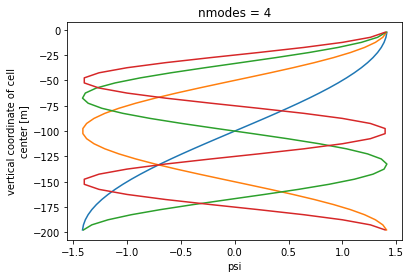

In [12]:
f,ax=plt.subplots()
df.psi[0].plot(ax=ax,y="Z")
df.psi[1].plot(ax=ax,y="Z")
df.psi[2].plot(ax=ax,y="Z")
df.psi[3].plot(ax=ax,y="Z")

In [13]:
print(df.psi[0].sum("Z").values)

4.440892098500626e-16


In [14]:
df['ce']=xr.DataArray(ce,coords=[nmodes],dims=["nmodes"])

In [15]:
iy1=50
VW=grid.interp(ds1['VVEL'],axis=('X','Y'),boundary='extrapolate')
for iy in range(iy1,iy1+1):
    U0=(ds1['UVEL']*ds1['drF']*ds1['hFacW']*ds1['maskW']).isel(YC=iy).sum('Z')/(ds1.drF*ds1.hFacW*ds1.maskW).isel(YC=iy).sum('Z')
    VW0=(VW*ds1['drF']*ds1['hFacW']*ds1['maskW']).isel(YC=iy).sum('Z')/(ds1.drF*ds1.hFacW*ds1.maskW).isel(YC=iy).sum('Z')
    VS0=(ds1['VVEL'].isel(YG=iy)*ds1['drF']*ds1['hFacS']*ds1['maskS']).sum('Z')/(ds1.drF*ds1.hFacS*ds1.maskS).isel(YG=iy).sum('Z')
    PW=grid.interp(ds1['PHIHYD'],axis='X',boundary='extrapolate')
    PS=grid.interp(ds1['PHIHYD'],axis='Y',boundary='extrapolate')
    #print(PW[2,60:63,723:726].values)
    #print(PS[2,60:63,723:726].values)
    PW0=(PW*ds1['drF']*ds1['hFacW']*ds1['maskW']).isel(YC=iy).sum('Z')/(ds1.drF*ds1.hFacW*ds1.maskW).isel(YC=iy).sum('Z')
    PS0=(PS*ds1['drF']*ds1['hFacS']*ds1['maskS']).isel(YG=iy).sum('Z')/(ds1.drF*ds1.hFacS*ds1.maskS).isel(YG=iy).sum('Z')
    #print(PW0[60:63,723:726].values)

    up=(ds1.UVEL.isel(YC=iy)-U0).where(ds1.maskW.isel(YC=iy)!=0,np.nan)
    print('processed up')
    vwp=(VW.isel(YC=iy)-VW0).where(ds1.maskW.isel(YC=iy)!=0,np.nan)
    vsp=(ds1.VVEL.isel(YG=iy)-VS0).where(ds1.maskS.isel(YG=iy)!=0,np.nan)
    print('vp')
    ppw=((PW-PW0).isel(YC=iy)).where(ds1.maskW.isel(YC=iy)!=0,np.nan)
    print('ppw')
    pps=((PS-PS0).isel(YG=iy)).where(ds1.maskS.isel(YG=iy)!=0,np.nan)
    print('pps')
    del U0,VS0,VW0,PW0,PS0

    um=(up*df.psi*ds1.drF).sum("Z")/H
    pmw=(ppw*df.psi*ds1.drF).sum("Z")/H
    vms=(vsp*df.psi*ds1.drF).sum("Z")/H
    vmw=(vwp*df.psi*ds1.drF).sum("Z")/H
    pms=(pps*df.psi*ds1.drF).sum("Z")/H
    fxm=um*pmw*H
    fym=vms*pms*H
    EKm=0.5*(um*um+vmw*vmw)*H
    EPm=0.5*(pmw*pmw/df.ce/df.ce)*H
    Em=EKm+EPm
    print(Em)
    cEm=xr.concat([-df.ce*Em[:, :720,:], df.ce*Em[:, 720:,:]], dim="XG")
    print(cEm)

BCrad=0
del vsp,pps

processed up
vp
ppw
pps
<xarray.DataArray (TidalCycles: 48, XG: 1440, nmodes: 37)>
dask.array<add, shape=(48, 1440, 37), dtype=float64, chunksize=(1, 1439, 37), chunktype=numpy.ndarray>
Coordinates:
    YC           float64 1.262e+03
  * XG           (XG) float64 3.411e-13 713.5 1.407e+03 ... 7.859e+04 7.929e+04
    dyG          (XG) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
    dxC          (XG) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
    rAw          (XG) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
    maskInW      (XG) bool dask.array<chunksize=(1440,), meta=np.ndarray>
    iter         (TidalCycles) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time         (TidalCycles) timedelta64[ns] 2 days 14:00:00 ... 3 days 14:...
  * TidalCycles  (TidalCycles) float64 5.0 5.042 5.083 ... 6.875 6.917 6.958
  * nmodes       (nmodes) int64 1 2 3 4 5 6 7 8 9 ... 29 30 31 32 33 34 35 36 37
<xarray.DataArray (nmodes: 37, TidalCycles: 48, XG: 1440)>
da

Text(0.5, 1.0, 'fx1 [m4/s3]')

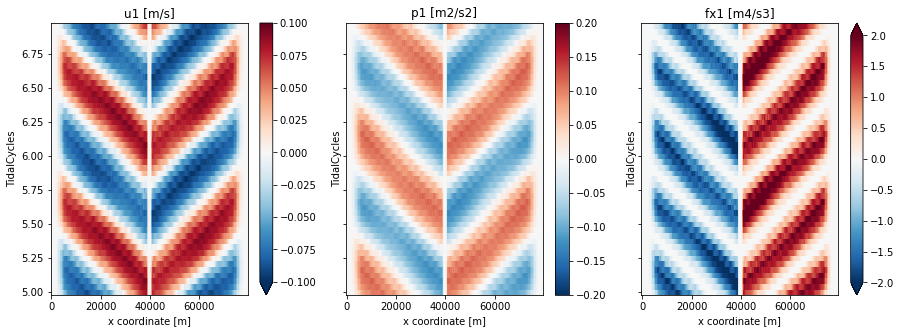

In [16]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

um.sel(nmodes=1).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.1,vmax=0.1,rasterized=True)
ax[0].set_title("u1 [m/s]")

pmw.sel(nmodes=1).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.2,vmax=0.2,rasterized=True)
ax[1].set_title("p1 [m2/s2]")

fxm.sel(nmodes=1).plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-2,vmax=2,rasterized=True)
ax[2].set_title("fx1 [m4/s3]")

Text(0.5, 1.0, 'fx2 [m4/s3]')

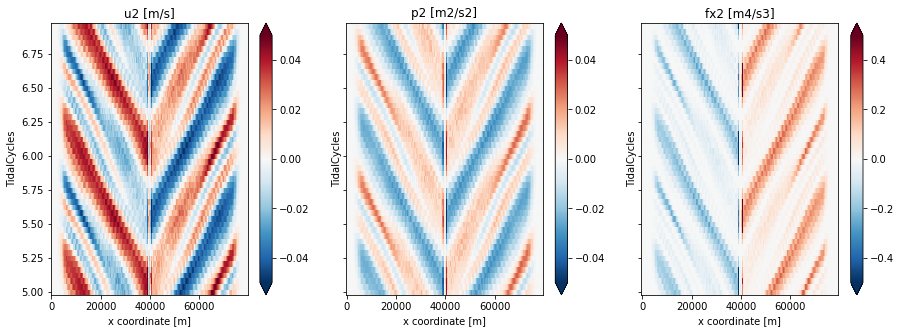

In [17]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

um.sel(nmodes=2).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.05,vmax=0.05,rasterized=True)
ax[0].set_title("u2 [m/s]")

pmw.sel(nmodes=2).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.05,vmax=0.05,rasterized=True)
ax[1].set_title("p2 [m2/s2]")

fxm.sel(nmodes=2).plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-0.5,vmax=0.5,rasterized=True)
ax[2].set_title("fx2 [m4/s3]")

Text(0.5, 1.0, 'fx3 [m4/s3]')

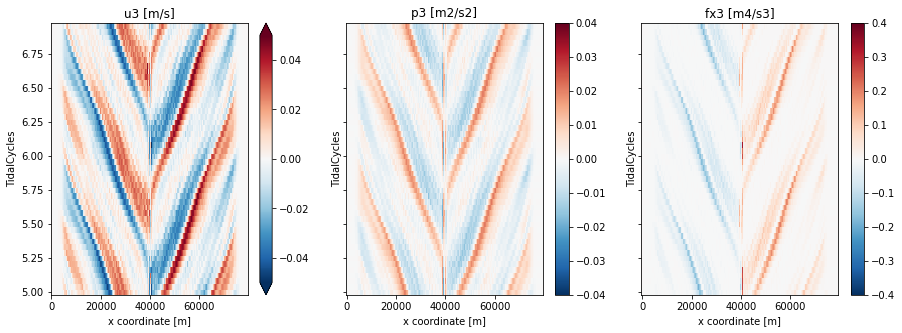

In [18]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

um.sel(nmodes=3).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.05,vmax=0.05,rasterized=True)
ax[0].set_title("u3 [m/s]")

pmw.sel(nmodes=3).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.04,vmax=0.04,rasterized=True)
ax[1].set_title("p3 [m2/s2]")

fxm.sel(nmodes=3).plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-0.4,vmax=0.4,rasterized=True)
ax[2].set_title("fx3 [m4/s3]")

Text(0.5, 1.0, 'fx4 [m4/s3]')

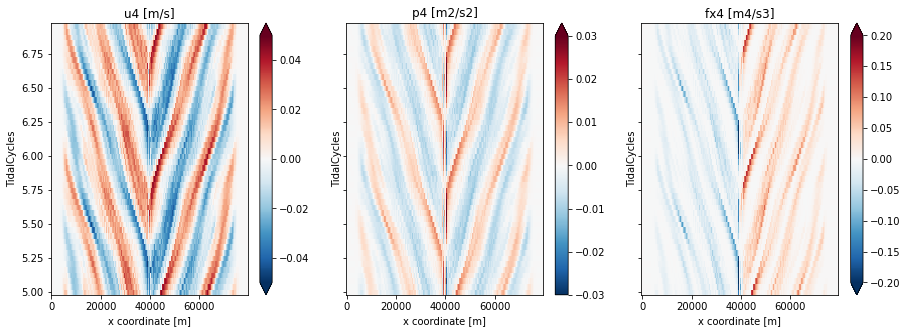

In [19]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

um.sel(nmodes=4).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.05,vmax=0.05,rasterized=True)
ax[0].set_title("u4 [m/s]")

pmw.sel(nmodes=4).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.03,vmax=0.03,rasterized=True)
ax[1].set_title("p4 [m2/s2]")

fxm.sel(nmodes=4).plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-0.2,vmax=0.2,rasterized=True)
ax[2].set_title("fx4 [m4/s3]")

Text(0.5, 1.0, 'fx5 [m4/s3]')

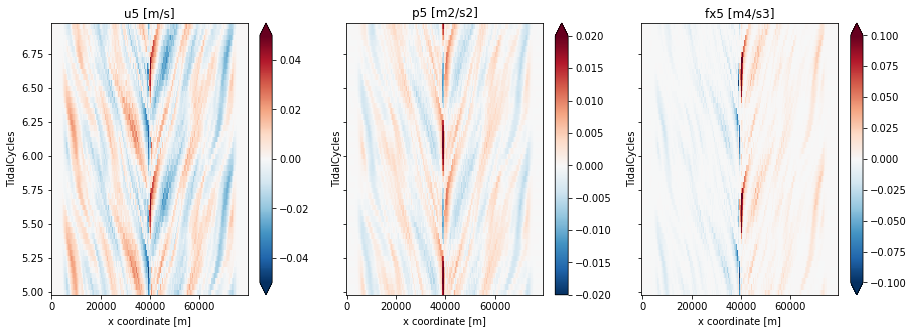

In [20]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

um.sel(nmodes=5).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.05,vmax=0.05,rasterized=True)
ax[0].set_title("u5 [m/s]")

pmw.sel(nmodes=5).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.02,vmax=0.02,rasterized=True)
ax[1].set_title("p5 [m2/s2]")

fxm.sel(nmodes=5).plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-0.1,vmax=0.1,rasterized=True)
ax[2].set_title("fx5 [m4/s3]")

Text(0.5, 1.0, 'fx6 [m4/s3]')

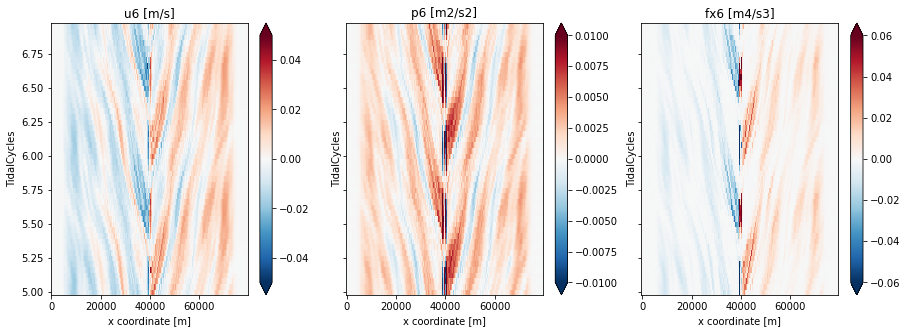

In [21]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

um.sel(nmodes=6).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.05,vmax=0.05,rasterized=True)
ax[0].set_title("u6 [m/s]")

pmw.sel(nmodes=6).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.01,vmax=0.01,rasterized=True)
ax[1].set_title("p6 [m2/s2]")

fxm.sel(nmodes=6).plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-0.06,vmax=0.06,rasterized=True)
ax[2].set_title("fx6 [m4/s3]")

Text(0.5, 1.0, 'total sum of cE')

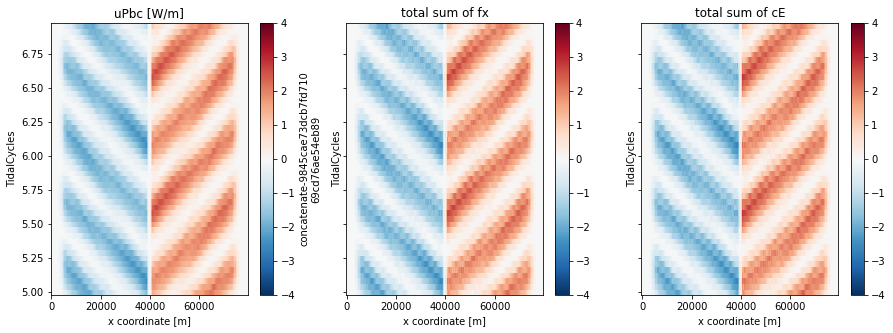

In [22]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

uPbc.isel(YC=iy1).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-4,vmax=4)
ax[0].set_title("uPbc [W/m]")

fxm.sum("nmodes").plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-4,vmax=4)
ax[1].set_title("total sum of fx")

cEm.sum("nmodes").plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-4,vmax=4)
ax[2].set_title("total sum of cE")

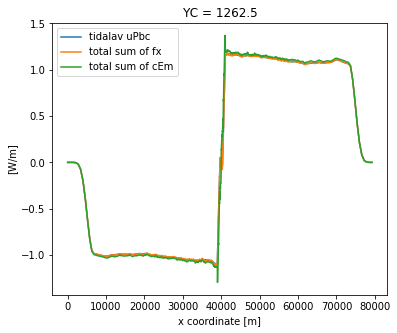

In [23]:
f, ax =plt.subplots(1,1,figsize=(6,5))

uPbc.isel(YC=iy1).mean("TidalCycles").plot(ax=ax,label="tidalav uPbc")
fxm.sum("nmodes").mean("TidalCycles").plot(ax=ax,label="total sum of fx")
cEm.sum("nmodes").mean("TidalCycles").plot(ax=ax,label="total sum of cEm")
ax.set_ylabel("[W/m]")
ax.legend()

In [24]:
EK = 0.5*(ds1.UVEL*ds1.UVEL+VW*VW)
EKp = 0.5*(up*up+vwp*vwp)
print(EK)
print(EKp)

<xarray.DataArray (TidalCycles: 48, Z: 40, YC: 120, XG: 1440)>
dask.array<mul, shape=(48, 40, 120, 1440), dtype=float64, chunksize=(1, 40, 119, 1439), chunktype=numpy.ndarray>
Coordinates:
  * YC           (YC) float64 12.5 37.5 62.5 ... 2.938e+03 2.962e+03 2.988e+03
  * XG           (XG) float64 3.411e-13 713.5 1.407e+03 ... 7.859e+04 7.929e+04
  * Z            (Z) float64 -2.5 -7.5 -12.5 -17.5 ... -187.5 -192.5 -197.5
    dyG          (YC, XG) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    dxC          (YC, XG) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    rAw          (YC, XG) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    drF          (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    PHrefC       (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    hFacW        (Z, YC, XG) float64 dask.array<chunksize=(40, 120, 1440), meta=np.ndarray>
    maskW        (Z, YC, XG) bool dask.array<chunksize=(40, 120, 1440), meta=np.n

Text(0.5, 1.0, 'total sum of EKn')

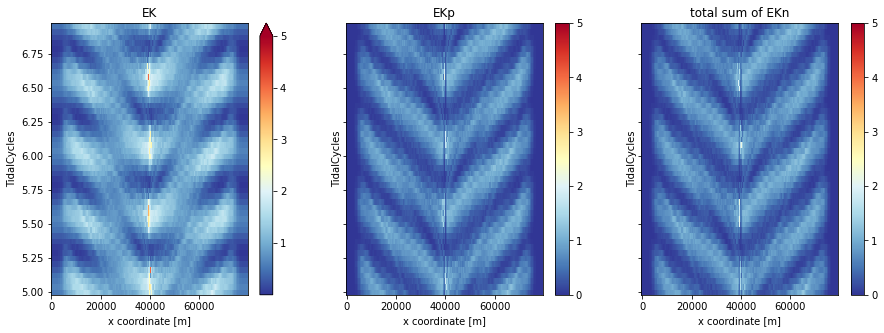

In [25]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

(EK*ds1['drF']*ds1['hFacW']*ds1['maskW']).sum('Z').isel(YC=iy1).plot(ax=ax[0],y="TidalCycles",cmap="RdYlBu_r",vmax=5)
ax[0].set_title("EK")

(EKp*ds1['drF']*ds1['hFacW']*ds1['maskW']).isel(YC=iy1).sum('Z').plot(ax=ax[1],y="TidalCycles",cmap="RdYlBu_r",vmax=5)
ax[1].set_title("EKp")

EKm.sum("nmodes").plot(ax=ax[2],y="TidalCycles",cmap="RdYlBu_r",vmax=5)
ax[2].set_title("total sum of EKn")

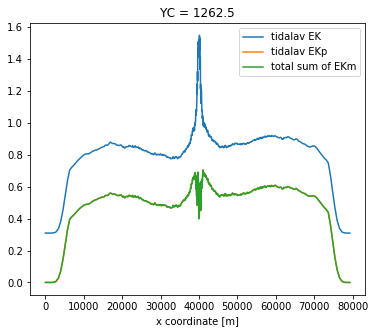

In [26]:
f, ax =plt.subplots(1,1,figsize=(6,5))

(EK*ds1['drF']*ds1['hFacW']*ds1['maskW']).sum('Z').isel(YC=iy1).mean("TidalCycles").plot(ax=ax,label="tidalav EK")
(EKp*ds1['drF']*ds1['hFacW']*ds1['maskW']).sum('Z').isel(YC=iy1).mean("TidalCycles").plot(ax=ax,label="tidalav EKp")
EKm.sum("nmodes").mean("TidalCycles").plot(ax=ax,label="total sum of EKm")
ax.legend()

In [27]:
rhow=rhoNil*(-(alpha*(ds1.THETA-ds1.tRef)))

In [28]:
print(rhow.isel(TidalCycles=0,YC=50,XC=700).values)

[ 0.16717379  0.0153301  -0.09732523 -0.16524373 -0.118273   -0.04825543
  0.04772586  0.16820414  0.29279     0.40578278  0.3828516   0.41456851
  0.46210495  0.50311139  0.45758529  0.38797362  0.31665387  0.25204665
  0.17282782  4.91738367  4.71334286  4.50930204  4.30526122  4.10122041
  3.89717959  3.69313878  3.48909796  3.28505714  3.08101633  2.87697551
  2.67293469  2.46889388  2.26485306  2.06081224  1.85677143  1.65273061
  1.4486898   1.24464898  1.04060816  0.83656735]


In [29]:
EP=g*g*rhow*rhow/(2*rhoNil*rhoNil*ds1.Ns0)

Text(0.5, 1.0, 'total sum of EPn')

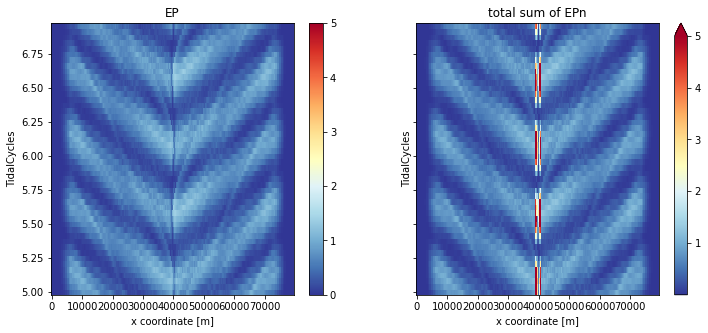

In [30]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

(EP*ds1['drF']*ds1['hFacC']*ds1['maskC']).sum('Z').isel(YC=iy1).plot(ax=ax[0],y="TidalCycles",cmap="RdYlBu_r",vmax=5)
ax[0].set_title("EP")

EPm.sum("nmodes").plot(ax=ax[1],y="TidalCycles",cmap="RdYlBu_r",vmax=5)
ax[1].set_title("total sum of EPn")

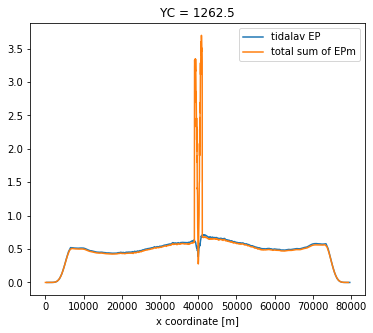

In [31]:
f, ax =plt.subplots(1,1,figsize=(6,5))

(EP*ds1['drF']*ds1['hFacC']*ds1['maskC']).sum('Z').isel(YC=iy1).mean("TidalCycles").plot(ax=ax,label="tidalav EP")
EPm.sum("nmodes").mean("TidalCycles").plot(ax=ax,label="total sum of EPm")
ax.legend()

Text(0.5, 1.0, 'Fx1 at Y= 1262.500000')

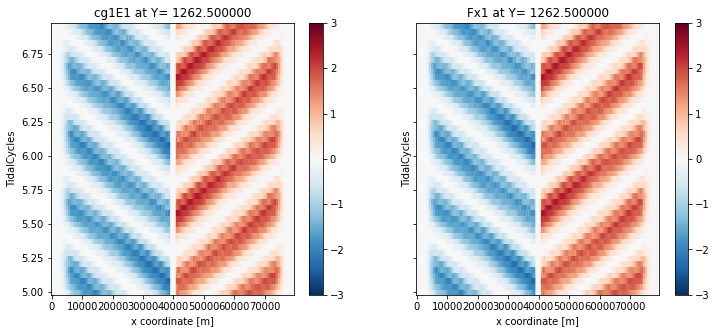

In [44]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cEm.sel(nmodes=1).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-3,vmax=3,rasterized=True)
ax[0].set_title("cg1E1 at Y= %1f" %yc[iy1])

fxm.sel(nmodes=1).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-3,vmax=3,rasterized=True)
ax[1].set_title("Fx1 at Y= %1f" %yc[iy1])

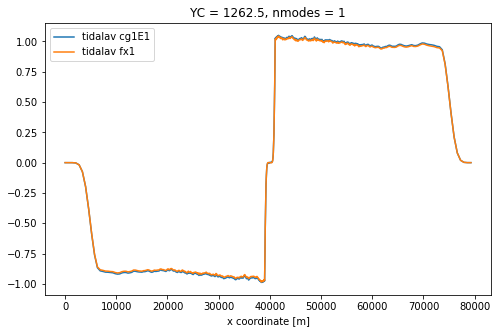

In [33]:
f, ax =plt.subplots(1,1,figsize=(8,5))

cEm.mean("TidalCycles").sel(nmodes=1).plot(ax=ax,label="tidalav cg1E1")
fxm.mean("TidalCycles").sel(nmodes=1).plot(ax=ax,label="tidalav fx1")

ax.legend()

Text(0.5, 1.0, 'Fx2 at Y= 1262.500000')

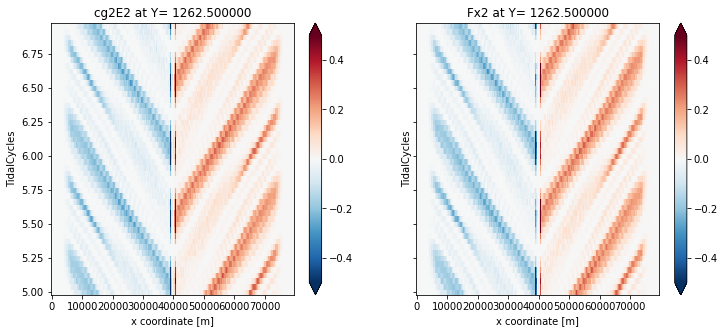

In [45]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cEm.sel(nmodes=2).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.5,vmax=0.5)
ax[0].set_title("cg2E2 at Y= %1f" %yc[iy1])

fxm.sel(nmodes=2).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.5,vmax=0.5)
ax[1].set_title("Fx2 at Y= %1f" %yc[iy1])

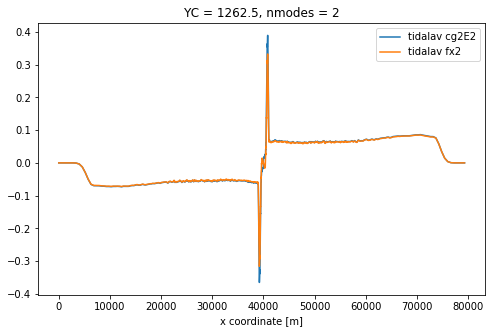

In [35]:
f, ax =plt.subplots(1,1,figsize=(8,5))

cEm.mean("TidalCycles").sel(nmodes=2).plot(ax=ax,label="tidalav cg2E2")
fxm.mean("TidalCycles").sel(nmodes=2).plot(ax=ax,label="tidalav fx2")

ax.legend()

Text(0.5, 1.0, 'Fx3 at Y= 1262.500000')

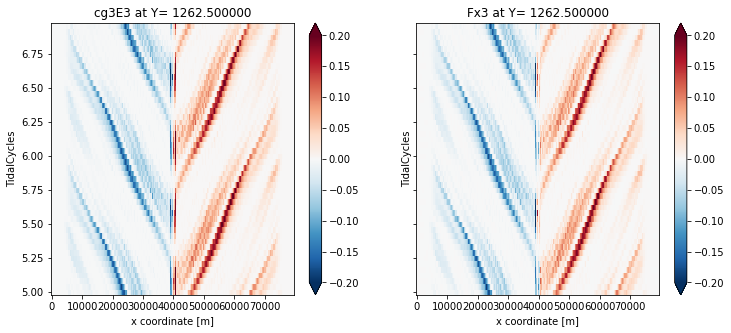

In [46]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cEm.sel(nmodes=3).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.2,vmax=0.2,rasterized=True)
ax[0].set_title("cg3E3 at Y= %1f" %yc[iy1])

fxm.sel(nmodes=3).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.2,vmax=0.2,rasterized=True)
ax[1].set_title("Fx3 at Y= %1f" %yc[iy1])

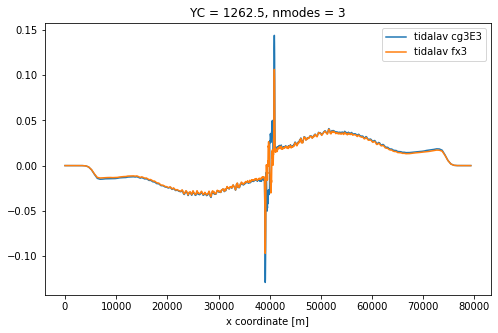

In [37]:
f, ax =plt.subplots(1,1,figsize=(8,5))

cEm.mean("TidalCycles").sel(nmodes=3).plot(ax=ax,label="tidalav cg3E3")
fxm.mean("TidalCycles").sel(nmodes=3).plot(ax=ax,label="tidalav fx3")

ax.legend()

Text(0.5, 1.0, 'Fx4 at Y= 1262.500000')

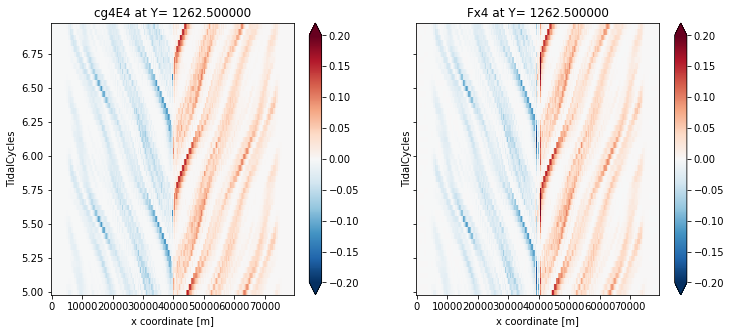

In [47]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cEm.sel(nmodes=4).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.2,vmax=0.2)
ax[0].set_title("cg4E4 at Y= %1f" %yc[iy1])

fxm.sel(nmodes=4).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.2,vmax=0.2)
ax[1].set_title("Fx4 at Y= %1f" %yc[iy1])

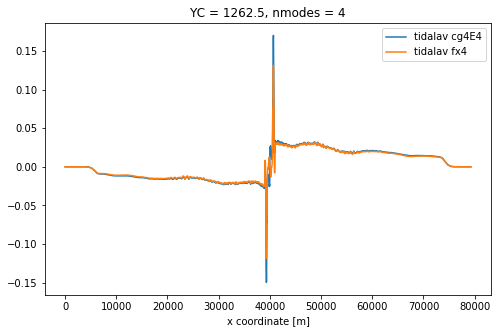

In [39]:
f, ax =plt.subplots(1,1,figsize=(8,5))

cEm.mean("TidalCycles").sel(nmodes=4).plot(ax=ax,label="tidalav cg4E4")
fxm.mean("TidalCycles").sel(nmodes=4).plot(ax=ax,label="tidalav fx4")

ax.legend()

Text(0.5, 1.0, 'Fx5 at Y= 1262.500000')

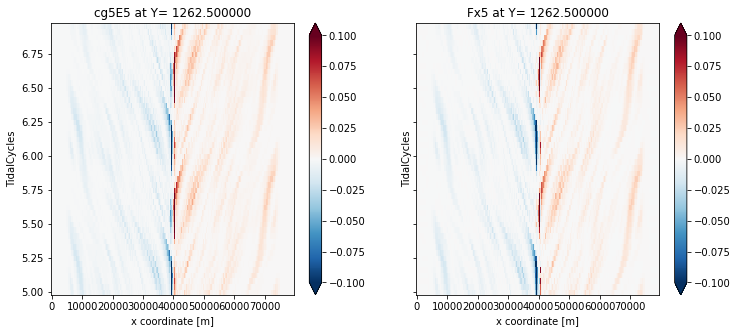

In [49]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cEm.sel(nmodes=5).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.1,vmax=0.1,rasterized=True)
ax[0].set_title("cg5E5 at Y= %1f" %yc[iy1])

fxm.sel(nmodes=5).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.1,vmax=0.1,rasterized=True)
ax[1].set_title("Fx5 at Y= %1f" %yc[iy1])

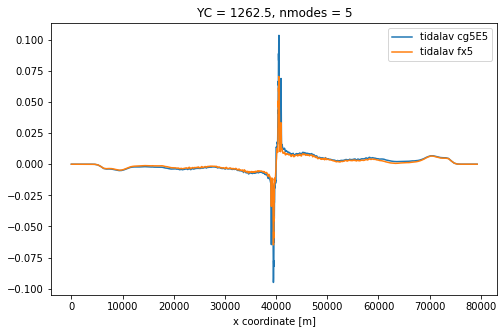

In [41]:
f, ax =plt.subplots(1,1,figsize=(8,5))

cEm.mean("TidalCycles").sel(nmodes=5).plot(ax=ax,label="tidalav cg5E5")
fxm.mean("TidalCycles").sel(nmodes=5).plot(ax=ax,label="tidalav fx5")

ax.legend()

Text(0.5, 1.0, 'Fx6 at Y= 1262.500000')

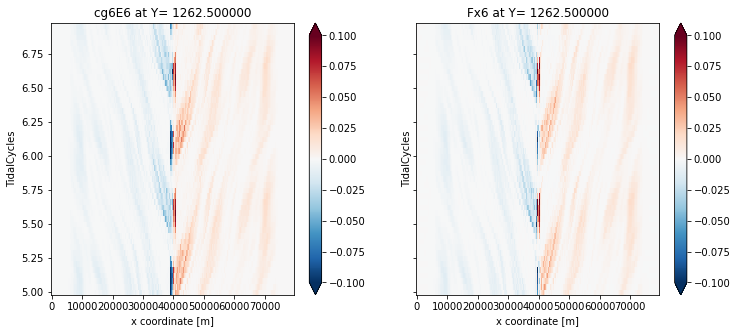

In [50]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cEm.sel(nmodes=6).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.1,vmax=0.1,rasterized=True)
ax[0].set_title("cg6E6 at Y= %1f" %yc[iy1])

fxm.sel(nmodes=6).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.1,vmax=0.1,rasterized=True)
ax[1].set_title("Fx6 at Y= %1f" %yc[iy1])

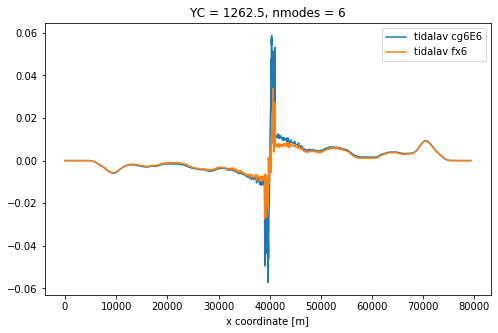

In [43]:
f, ax =plt.subplots(1,1,figsize=(8,5))

cEm.mean("TidalCycles").sel(nmodes=6).plot(ax=ax,label="tidalav cg6E6")
fxm.mean("TidalCycles").sel(nmodes=6).plot(ax=ax,label="tidalav fx6")

ax.legend()